# We analyze IAAF 100m and 200m all-time men and women lists # 

In [1]:
import sys
import requests
import lxml.html as lh
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split

/home/roberto/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Scraping the data from the IAAF website to build pandas DataFrames ##


In [2]:
# user controls these three variables

# choose gender: men or women
igender1 = 'men'

# choose whether to include both genders (True) or not (False)
inclboth = True

# choose number of pages of results we want to include from the IAAF lists (for both genders)
# 0<npage<=17
npage=15

In [3]:
# determine other gender
if igender1=='women':
    igender2 = 'men'
elif igender1=='men':
    igender2 = 'women'
else:
    sys.exit("I know that gender is non-binary but not for the IAAF. Stop.")

In [4]:
# need this header to open the page from my laptop
headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:64.0) Gecko/20100101 Firefox/64.0'}

# create empty final lists
tr1_elements_final = []
tr2_elements_final = []

ip=1
while ip<=npage:
    
    # get url and create a page
    url1='http://www.iaaf.org/records/all-time-toplists/sprints/100-metres/outdoor/' + igender1 + '/senior?page=' + str(ip)
    url2='http://www.iaaf.org/records/all-time-toplists/sprints/200-metres/outdoor/' + igender1 + '/senior?page=' + str(ip)
    page1 = requests.get(url1, headers=headers)
    page2 = requests.get(url2, headers=headers)
    
    # store the contents of the website
    doc1 = lh.fromstring(page1.content)
    doc2 = lh.fromstring(page2.content)
    
    # parse data that are stored between <tr>..</tr> of HTML
    tr1_elements = doc1.xpath('//tr')
    tr2_elements = doc2.xpath('//tr')
    
    if ip==1:
        # in our case the table starts at position 18 (with the header)
        tr1_elements_final += tr1_elements[18:]
        tr2_elements_final += tr2_elements[18:]
    else:
        # without including the header again
        tr1_elements_final += tr1_elements[19:]
        tr2_elements_final += tr2_elements[19:]
        
    ip+=1
    
# include other gender's results if required
if inclboth:
    ip=1
    while ip<=npage:
        url1='http://www.iaaf.org/records/all-time-toplists/sprints/100-metres/outdoor/' + igender2 + '/senior?page=' + str(ip)
        url2='http://www.iaaf.org/records/all-time-toplists/sprints/200-metres/outdoor/' + igender2 + '/senior?page=' + str(ip)
        page1 = requests.get(url1, headers=headers)
        page2 = requests.get(url2, headers=headers)
        doc1 = lh.fromstring(page1.content)
        doc2 = lh.fromstring(page2.content)
        tr1_elements = doc1.xpath('//tr')
        tr2_elements = doc2.xpath('//tr')
    
        # without including the header again
        tr1_elements_final += tr1_elements[19:]
        tr2_elements_final += tr2_elements[19:]
        ip+=1

In [5]:
# create empty list
col1=[]
col2=[]

#For each row, store each first element (header) and an empty list
i=0
for t in tr1_elements_final[0]:
    i+=1
    name=t.text_content()
    name=name.strip()
    #print '%d:"%s"'%(i,name)
    col1.append((name,[]))

i=0
for t in tr2_elements_final[0]:
    i+=1
    name=t.text_content()
    name=name.strip()
    #print '%d:"%s"'%(i,name)
    col2.append((name,[]))

In [6]:
#Since our first row is the header, data is stored on the second row onwards
for j in range(1,len(tr1_elements_final)):
    #T is our j'th row
    T=tr1_elements_final[j]
    
    #If row is not of size 11, the //tr data is not from our table 
    if len(T)!=11:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content()
        data=data.strip()
        #Append the data to the empty list of the i'th column
        col1[i][1].append(data)
        #Increment i for the next column
        i+=1
        
for j in range(1,len(tr2_elements_final)):
    #T is our j'th row
    T=tr2_elements_final[j]
    
    #If row is not of size 11, the //tr data is not from our table 
    if len(T)!=11:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content()
        data=data.strip()
        #Append the data to the empty list of the i'th column
        col2[i][1].append(data)
        #Increment i for the next column
        i+=1

In [7]:
Dict1={title:column for (title,column) in col1}
Dict2={title:column for (title,column) in col2}

# there's a key with all blank entries so we get rid of it
del Dict1['']
del Dict2['']

# create DataFrames
df1=pd.DataFrame(Dict1)
df2=pd.DataFrame(Dict2)

# changing header name
df1.rename(columns={'Mark':'100m'}, inplace=True)
df2.rename(columns={'Mark':'200m'}, inplace=True)

## We analyze the 100m list and visualize our findings ##

### I. Nationalities with most all-timers ####

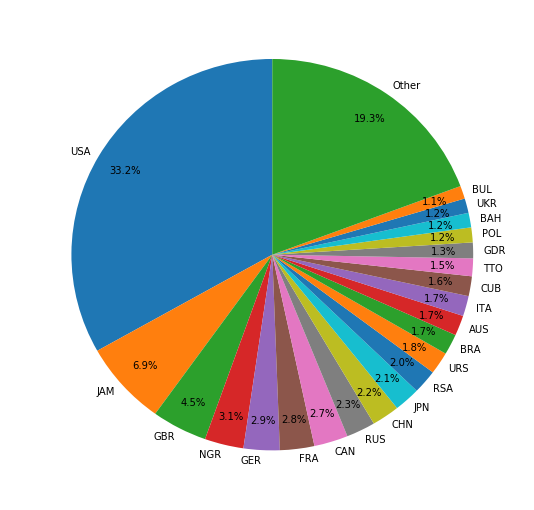

In [138]:
# create ranking
df1natcount=df1['Nat'].value_counts()
df1natcount_above=df1natcount[df1natcount>=30]
df1natcount_below=pd.Series([len(df1.index)-df1natcount_above.sum()],index=['Other'])
df1natcount_final=df1natcount_above.append(df1natcount_below)

# plot
plt.figure(figsize=(9,9))
df1natcount_final.plot(kind='pie', autopct='%1.1f%%', pctdistance=0.85, labeldistance=1.05, startangle=90, shadow=False, legend = False, fontsize=10)

plt.axis('off')
plt.show()

### II. Age at PB ###

In [268]:
# function to convert age in days to age in years
def get_age(ndays):
    # handle NaNs: assign negative age
    if ndays!=ndays:
        age=-1.0
    # account for leap years    
    else:
        age=float(ndays/365.25)
    return age

# get DOBs and Dates
df1_dobs=pd.to_datetime(df1['DOB'])
df1_dates=pd.to_datetime(df1['Date'])

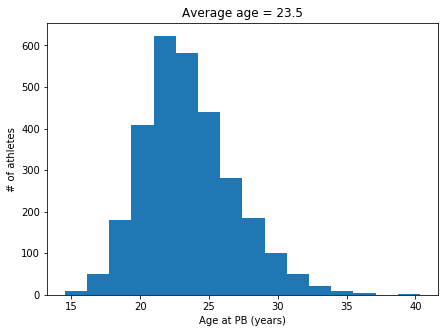

In [269]:
# get ages at PBs
df1_timediff=df1_dates-df1_dobs
df1_timediff=df1_timediff.dt.days
df1_ages=pd.Series([get_age(item) for item in df1_timediff])
df1_ages_final=df1_ages[df1_ages>0]

# plot
plt.figure(figsize=(7,5))
plt.hist(df1_ages_final, bins=16)
plt.title('Average age = %.1f' % df1_ages_final.mean())
plt.xlabel('Age at PB (years)')
plt.ylabel('# of athletes')
plt.show()

### III. Youngest and oldest in the all-time lists ###

## We create a combined 100m-200m list and we study whether a regression model can be built between 100m and 200m PBs of all-time athletes ##

In [8]:
df3=pd.merge(df1[['Competitor','100m']], df2[['Competitor','200m']], on='Competitor')

Text(0,0.5,u'200m (s)')

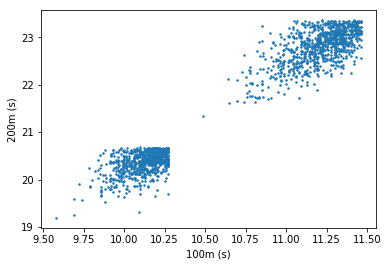

In [9]:
# convert to float
df3 = df3.astype({'100m': float, '200m': float})

# create X and Y arrays for regression
Xval = df3['100m']
Yval = df3['200m']

# split X into random train and test sets
X_train, X_test, y_train, y_test = train_test_split(Xval,Yval,test_size=0.3)

# scatter plot
ax = df3.plot(x='100m', y='200m', style='.', ms=3, legend=False)
ax.set_xlabel("100m (s)")
ax.set_ylabel("200m (s)")

### Performing linear regression using Statsmodels ###


In [10]:
#Xvalconst = sm.add_constant(Xval)

#modelsm = sm.OLS(Yval, Xvalconst).fit()

#Ypredictionssm = modelsm.predict(Xvalconst)
#modelsm.summary()

In [11]:
#modelsm.predict([[1.0,9.90]])

### Performing linear regression using scikit-learn LinearRegression ###

In [12]:
# LinearRegression
lm = linear_model.LinearRegression()
lm.fit(X_train.values.reshape(-1,1),y_train)

# model predictions of test set
Ypredictionslm = lm.predict(X_test.values.reshape(-1,1))

In [13]:
# get R-squared
R2lm=lm.score(X_train.values.reshape(-1,1),y_train)
print 'R2_lm = ',R2lm

# get slope
coeflm=lm.coef_
print 'coeff_lm = ',coeflm

# get intercept
constlm=lm.intercept_
print 'intercept_lm = ',constlm

# test model for a random input
lm.predict([[9.99]])

R2_lm =  0.9485740579707512
coeff_lm =  [2.17924691]
intercept_lm =  -1.646807745826539


array([20.12386887])

### Performing linear regression using scikit-learn SGDRegressor (Stochastic Gradient Descent) ### 

In [14]:
# SGDRegressor
clf = linear_model.SGDRegressor(max_iter=1000, tol=1e-3)
clf.fit(X_train.values.reshape(-1,1),y_train)

# model predictions of test set
Ypredictionsclf = clf.predict(X_test.values.reshape(-1,1))

In [15]:
# get R-squared
R2clf=clf.score(X_train.values.reshape(-1,1),y_train)
print 'R2_clf = ',R2clf

# get slope
coefclf=clf.coef_
print 'coeff_clf = ',coefclf

# get intercept
constclf=clf.intercept_
print 'intercept_clf = ',constclf

# test model for a random input
clf.predict([[9.99]])

R2_clf =  0.9342091362365064
coeff_clf =  [2.02126438]
intercept_clf =  [0.16954637]


array([20.36197754])

### Comparison between LinearRegression and SGDRegressor ###

In [16]:
# % difference between truth and predictions for test set for LinearRegressions
lmdiff=100*(y_test-Ypredictionslm)/y_test

# % difference between truth and predictions for test set for SGDRegressor
clfdiff=100*(y_test-Ypredictionsclf)/y_test

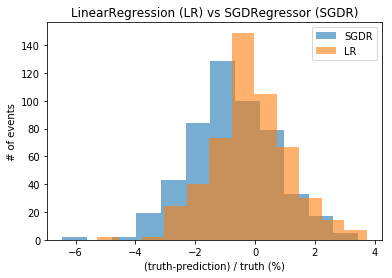

In [18]:
plt.hist(clfdiff, bins=12, alpha=0.6, label='SGDR')
plt.hist(lmdiff, bins=12, alpha=0.6, label='LR')
plt.legend(loc='upper right')
plt.title('LinearRegression (LR) vs SGDRegressor (SGDR)')
plt.xlabel('(truth-prediction) / truth (%)')
plt.ylabel('# of events')
plt.show()

To do list:  
- Try MLPRegressor
- Filter data (PBs years apart probably not very reliable etc)
- Do data analysis & visualization (youngest and oldest, rank years)  
- Check why some data are missing from dataframes (end of pages 15)

## References ###
[1] https://towardsdatascience.com/web-scraping-html-tables-with-python-c9baba21059  
[2] https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9  
[3] https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9    
[4] https://github.com/srcole/insightfellows  
[5] https://scikit-learn.org/stable/  
[6] https://stackoverflow.com/